## Mediterranean Sea Outflow Plume

This notebook plots the salinity plume flowing out of the Strait of Gibraltar in an east-west transect

In [1]:
import os

In [2]:
config = {
    "startyr": "1958",
    "endyr": "2020",
    "dora_id": "odiv-361",
    "pathPP": None,
    "observations":'WOA', # Options are WOA or RG
    "do_temp":False,
    "do_salt":True,
    "plot_GEBCO":False,
    "auto_dmget":False, #Automatically dmget files from archive
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
)

### Import Python Modules

In [3]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import copy 
import glob
import subprocess
import doralite
import momgrid as mg


In [4]:
# momgrid will use a directory of pre-computed weights (do I need this?)
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

In [5]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])



In [6]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varname = "ann"

chunk = "annual_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1958-1962.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1963-1967.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1968-1972.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1973-1977.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1978-1982.ann.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1983-1987.ann.nc
/archive/John.Krasting

In [7]:
if not "DORA_EXECUTE" in os.environ.keys():
    subprocess.run(["dmwho"])

MINUTES  USERNAME                  HOST    COMMAND FILES
  167.0  John.Krasting             an207   dmget     168


In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    cmd = ["dmget"]+filelist+[staticfile]
    
    if config['auto_dmget']:
        print("Calling dmget on files ...")
        _ = subprocess.check_output(cmd)
    else:
        print("Paste to terminal to dmget files ...")
        out_string=''
        for cell in cmd:
            out_string+=' '+cell
        print(out_string)

Paste to terminal to dmget files ...
 dmget /archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1958-1962.ann.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1963-1967.ann.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1968-1972.ann.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1973-1977.ann.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1978-1982.ann.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20231114/om5_b03_bbl_tidalbg/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annu

In [9]:
#Loading up some obs data

# Roemmich and Gilson Argo based data
RG_argo={}
RG_argo['DIR'] = '/net2/bgr/Data/ARGO/RG_Clim/Updated/'
RG_argo['T_file'] = 'RG_ArgoClim_Temp_Extended_200401-202010.nc'
RG_argo['S_file'] = 'RG_ArgoClim_Psal_Extended_200401-202010.nc'
RG_argo['hndl'] = xr.open_mfdataset([RG_argo['DIR']+RG_argo['T_file'],RG_argo['DIR']+RG_argo['S_file']],decode_times=False)
RG_argo['hndl']['T'] = RG_argo['hndl'].ARGO_TEMPERATURE_MEAN
RG_argo['hndl']['S'] = RG_argo['hndl'].ARGO_SALINITY_MEAN
RG_argo['hndl'] = RG_argo['hndl'].assign_coords(Z=(('PRESSURE'),RG_argo['hndl'].PRESSURE.values*10000/(1035*9.81)))

XX = RG_argo['hndl'].LONGITUDE.values
XX[XX>60]-=360
xi=np.argsort(XX)
RG_argo['hndl']['LONGITUDE']=(XX[xi])
RG_argo['hndl']['S']=(('Z','LATITUDE','LONGITUDE'),RG_argo['hndl'].S.values[:,:,xi],)
RG_argo['hndl']['T']=(('Z','LATITUDE','LONGITUDE'),RG_argo['hndl'].T.values[:,:,xi])

# World ocean atlas data
WOA={}
WOA['DIR'] = '/net3/bgr/Datasets/WOA/'
WOA['T_file'] = WOA['DIR']+'woa23_decav91C0_t00_04.nc'
WOA['S_file'] = WOA['DIR']+'woa23_decav91C0_s00_04.nc'
WOA['hndl'] = xr.open_mfdataset([WOA['T_file'],WOA['S_file']],decode_times=False).isel(time=0)[['s_an','t_an']]
XX=WOA['hndl'].lon.values
XX[XX>60]-=360
xi=np.argsort(XX)
WOA['hndl']['lon']=(XX[xi])
WOA['hndl']['s_an']=(('depth','lat','lon'),WOA['hndl'].s_an.values[:,:,xi],)
WOA['hndl']['t_an']=(('depth','lat','lon'),WOA['hndl'].t_an.values[:,:,xi])

#If requesting High Resolution topography
GEBCO={}
GEBCO['fname_gebco']  = "/archive/gold/datasets/topography/GEBCO_2023/GEBCO_2023.nc"
GEBCO['hndl'] = xr.open_dataset(GEBCO['fname_gebco'])


In [10]:
ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
model_type = ds.model
if ds.data.time.size>1:
    ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))[['thetao','so','z_i','geolon_c','geolat_c','geolon_u','geolat_u','geolon_v','geolat_v']]
    ds = ds.mean(dim='time')
else:
    ds = ds.data

static = xr.open_dataset(staticfile)

In [11]:
#Note that this can easily be configured for any other lat/lon transect within the regular grid
# it should be improved to work in tripolar region or with arbitrary transect directions

Transect = {}

Transect['Med']={}
Transect['Med']['Type']='Zonal'
Transect['Med']['LonLim'] = [-75,15]
Transect['Med']['Lat'] = 36
Transect['Med']['SaltLevels'] = np.linspace(35,36.6,21)
Transect['Med']['TempLevels'] = np.linspace(5,15,11)
Transect['Med']['ZMax'] = 5500


# Other transects worth looking at
# Transect['Med Narrow']={}
# Transect['Med Narrow']['Type']='Zonal'
# Transect['Med Narrow']['LonLim'] = [-8,-4]
# Transect['Med Narrow']['Lat'] = 35.9
# Transect['Med Narrow']['SaltLevels'] = list(np.arange(34.5,36,0.2))+[36,37,38,39,]
# Transect['Med Narrow']['TempLevels'] = np.linspace(5,20,16)
# Transect['Med Narrow']['ZMax'] = 1000

# Transect['Med Narrow NS']={}
# Transect['Med Narrow NS']['Type']='Meridional'
# Transect['Med Narrow NS']['Lon'] = -6.6
# Transect['Med Narrow NS']['LatLim'] = [34,37]
# Transect['Med Narrow NS']['SaltLevels'] = np.arange(35,37,0.2)
# Transect['Med Narrow NS']['TempLevels'] = np.linspace(5,20,16)
# Transect['Med Narrow NS']['ZMax'] = 1000

# Transect['Med Narrow NS2']={}
# Transect['Med Narrow NS2']['Type']='Meridional'
# Transect['Med Narrow NS2']['Lon'] = -8.55
# Transect['Med Narrow NS2']['LatLim'] = [34,37.25]
# Transect['Med Narrow NS2']['SaltLevels'] = np.arange(35,37,0.2)
# Transect['Med Narrow NS2']['TempLevels'] = np.linspace(5,20,16)
# Transect['Med Narrow NS2']['ZMax'] = 3500

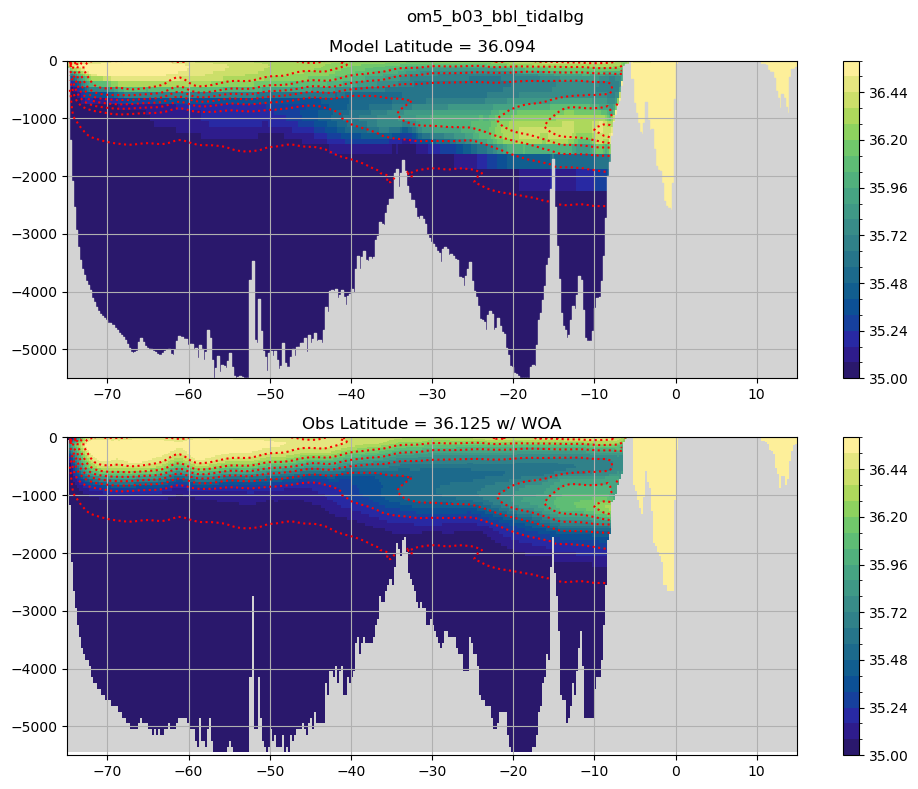

In [12]:

field_list =[]
if config['do_salt']:
    field_list+=['salt',]
if config['do_temp']:
    field_list+=['temp',]


for field in field_list:
    
    for Region in Transect:
        
        if (field=='salt'):
            # If printing the salinity transect
            levels = Transect[Region]['SaltLevels']
            varWOA='s_an'
            varMOM='so'
            varRG='S'
            cmap = copy.copy(cmocean.cm.haline)
            cmap.set_bad('lightgray')
            Proceed = True

        elif (field=='temp'):
            # If printing the temperature transect
            levels = Transect[Region]['TempLevels']
            varWOA='t_an'
            varRG='T'
            varMOM='thetao'
            cmap = copy.copy(cmocean.cm.thermal)
            cmap.set_bad('lightgray')

            Proceed = True

        else:

            Proceed = False

        if Proceed:
            
            if (Transect[Region]['Type']=='Zonal'):
                Lat = Transect[Region]['Lat']
                LonLim = Transect[Region]['LonLim']
                if config['observations']=='WOA':
                    XXobs = WOA['hndl'].lon
                    Cobs = WOA['hndl'][varWOA].sel(lat=Lat,method='nearest').values
                    Zobs = -WOA['hndl'].depth
                    YYobs = WOA['hndl'].lat.sel(lat=Lat,method='nearest').values
                elif config['observations']=='RG':
                    XXobs = RG_argo['hndl'].LONGITUDE
                    Zobs = -RG_argo['hndl'].Z
                    Cobs = RG_argo['hndl'][varRG].sel(LATITUDE=Lat,method='nearest').values
                    YYobs = RG_argo['hndl'].LATITUDE.sel(LATITUDE=Lat,method='nearest').values
                else:
                    print('Observations options are WOA and RG, notebook will likely fail due to incompatible choice.')
                    
                Zmod = -ds.z_i
                ii = np.argmin(abs(ds.geolat.values[:,0]-Lat))
                XXmodh = ds.geolon.values[ii,:]
                XXmod = ds.geolon_u.values[ii,:]
                YYmod = ds.geolat.values[ii,0]
                Cmod = ds[varMOM].isel(yh=ii)
                XLim = Transect[Region]['LonLim']
                LBL1='Obs Latitude = {:4.3f}'.format(YYobs)+' w/ '+config['observations']
                LBL2 = 'Model Latitude = {:4.3f}'.format(YYmod)
                Hmod = static.deptho.values[ii,:]
                if config['plot_GEBCO']:
                    Hobs = GEBCO['hndl'].elevation.sel(lat=slice(Lat-0.1,Lat+0.1)).sel(lon=slice(LonLim[0],LonLim[1])).mean(dim='lat').values
                    HobsP = GEBCO['hndl'].elevation.sel(lat=slice(Lat-0.1,Lat+0.1)).sel(lon=slice(LonLim[0],LonLim[1])).min(dim='lat').values
                    HobsM = GEBCO['hndl'].elevation.sel(lat=slice(Lat-0.1,Lat+0.1)).sel(lon=slice(LonLim[0],LonLim[1])).max(dim='lat').values
                    HobsX = GEBCO['hndl'].lon.sel(lon=slice(LonLim[0],LonLim[1])).values
                    HobsX[HobsX>60]-=360
                    xi=np.argsort(HobsX)
                    HobsX=(HobsX[xi])
                    Hobs=(Hobs[xi])
        
            elif (Transect[Region]['Type']=='Meridional'):
                Lon = Transect[Region]['Lon']
                LatLim = Transect[Region]['LatLim']
                if config['observations']=='WOA':
                    XXobs = WOA['hndl'].lat
                    Cobs = WOA['hndl'][varWOA].sel(lon=Lon,method='nearest').values
                    Zobs = -WOA['hndl'].depth
                    YYobs = WOA['hndl'].lon.sel(lon=Lon,method='nearest').values
                elif config['observations']=='RG':
                    XXobs = RG_argo['hndl'].LATITUDE
                    Zobs = -RG_argo['hndl'].Z
                    Cobs = RG_argo['hndl'].S.sel(LONGITUDE=Lon,method='nearest').values
                    YYobs = RG_argo['hndl'].LONGITUDE.sel(LONGITUDE=Lon,method='nearest').values
    
                Zmod = -ds.z_i
                ii = np.argmin(abs(ds.geolon.values[400,:]-Lon))
                XXmodh = ds.geolat.values[:,ii]
                YYmod = ds.geolon.values[400,ii]
                XXmod = ds.geolat_v.values[:,ii]
                Cmod = ds[varMOM].isel(xh=ii)
                XLim = Transect[Region]['LatLim']
                LBL1='Obs Longitude = {:4.3f}'.format(YYobs)+' w/ '+config['observations']
                LBL2 = 'Model Longitude = {:4.3f}'.format(YYmod)
                Hmod = static.deptho.values[:,ii]
                if config['plot_GEBCO']:
                    Hobs = GEBCO['hndl'].elevation.sel(lon=slice(Lon-0.1,Lon+0.1)).sel(lat=slice(LatLim[0],LatLim[1])).mean(dim='lon').values
                    HobsP = GEBCO['hndl'].elevation.sel(lon=slice(Lon-0.1,Lon+0.1)).sel(lat=slice(LatLim[0],LatLim[1])).max(dim='lon').values
                    HobsM = GEBCO['hndl'].elevation.sel(lon=slice(Lon-0.1,Lon+0.1)).sel(lat=slice(LatLim[0],LatLim[1])).min(dim='lon').values
                    HobsX = GEBCO['hndl'].lat.sel(lat=slice(LatLim[0],LatLim[1])).values
    
            f,a=plt.subplots(2,1,figsize=(10,8))
    
            ax=a[1]
            c=ax.pcolormesh(0.5*(XXobs[:-1]+XXobs[1:]),
                            0.5*(Zobs[:-1]+Zobs[1:]),
                            Cobs[1:-1,1:-1],
                            norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),
                            cmap=cmap)
            if config['plot_GEBCO']:
                ax.plot(HobsX,Hobs,'k-')
                ax.plot(HobsX,HobsP,'k',linewidth=0.2)
                ax.plot(HobsX,HobsM,'k',linewidth=0.2)
            ax.contour(XXobs,Zobs,Cobs,
                       levels=levels[::3],colors='r',linestyles=[':'])
            ax.set_xlim(XLim)
            ax.set_ylim(-Transect[Region]['ZMax'],0)
            plt.colorbar(c,ax=ax,ticks=levels[::3])
            ax.grid(True)
            ax.set_title(LBL1)
            ax=a[0]
            c=ax.pcolormesh(XXmod,Zmod,Cmod,
                            norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),
                            cmap=cmap)
            for ii in range(len(XXmodh)):
                ax.fill_between([XXmod[ii],XXmod[ii+1]],
                                [-5500,-5500],
                                [-Hmod[ii],-Hmod[ii]],color='lightgray')
            ax.contour(XXobs,Zobs,Cobs,
                       levels=levels[::3],colors='r',linestyles=[':'])
    
            ax.set_xlim(XLim)
            ax.set_ylim(-Transect[Region]['ZMax'],0)
            plt.colorbar(c,ax=ax,ticks=levels[::3])
            ax.grid(True)
            ax.set_title(LBL2)
            f.suptitle(expName)
            f.tight_layout()

    